In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

attention_dir = os.path.join(project_dir, 'modules/AttentionMap')
if attention_dir not in sys.path:
    sys.path.append(attention_dir)

sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir) 

import numpy as np
import torch, config
from torch import nn
import os

# Dataset

In [2]:
from derma.dataset import Derma, get_samples_weight
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation

transform = Compose([
        RandomHorizontalFlip(), 
        RandomVerticalFlip(),
        RandomRotation(90),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transform = Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

dataset = Derma(config.DATASET_DIR, transform=transform)
val_dataset = Derma(config.DATASET_DIR, transform=val_transform)

from torch.utils.data import DataLoader, random_split
val_size = int(0.1*len(dataset))
train_size = len(dataset) - val_size

train_set, val_set = random_split(dataset, [train_size, val_size])
val_set.dataset = val_dataset # Buscar una forma más elegante de hacerlo

train_sampler, _ = get_samples_weight(train_set)
train_loader = DataLoader(train_set, batch_size=64, shuffle=False, sampler=train_sampler)

val_sampler, _ = get_samples_weight(val_set)
val_loader = DataLoader(val_set, batch_size=512, shuffle=False, sampler=val_sampler)

Samples per class: [28137   976]
Weight per class: [3.55403917e-05 1.02459016e-03]
Samples per class: [3115  119]
Weight per class: [0.00032103 0.00840336]


# Model

In [3]:
from derma.architecture import InvertedResidual
from torchvision.models import MobileNetV2

inverted_residual_setting = [
        # t, c, n, s
        [1, 16, 1, 1],
        [6, 24, 2, 2],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        [6, 96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 1],
    ]

model = MobileNetV2(num_classes=2, inverted_residual_setting=inverted_residual_setting, block=InvertedResidual)

# Loading pretrained layers
model.features.load_state_dict(torch.load(os.path.join(config.RESULT_DIR, 'weights/encoder/cifar/encoder.pth')))

<All keys matched successfully>

# Train

In [4]:
from derma.utils import train
from torch.utils.tensorboard import SummaryWriter

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-6)
tb_writer = SummaryWriter(log_dir=os.path.join(config.RESULT_DIR, 'log/classification/derma'))
criterion = torch.nn.CrossEntropyLoss()

train(model, [train_loader, val_loader], optimizer, criterion, 10, tb_writer)

100%|██████████| 10/10 [13:22<00:00, 80.29s/epoch, acc=0.9029, tls=0.2376]


0.31529991967337473

In [5]:
save_dir = os.path.join(config.RESULT_DIR, 'weights/classifier/derma')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

torch.save(model.state_dict(), os.path.join(save_dir, 'model.pth'))

# Testing GradCam

In [6]:
model.load_state_dict(torch.load(os.path.join(config.RESULT_DIR, 'weights/classifier/derma/model.pth')))

<All keys matched successfully>

In [34]:
from captum.attr import GuidedGradCam

model.eval()
model.cpu()
guided_gc = GuidedGradCam(model, model.features[-1][0])
inputs, _ = next(iter(train_loader))
inputs.requires_grad = True

In [37]:
attribution = guided_gc.attribute(inputs, 0)

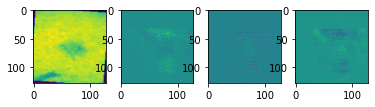

In [36]:
from matplotlib import pyplot as plt 
for i in range(4):
    plt.subplot(1, 4, i+1)
    if i == 0:
        plt.imshow(inputs[i, 0].detach().numpy())
    else:
        plt.imshow(attribution[0,i-1].detach().numpy())

plt.show()

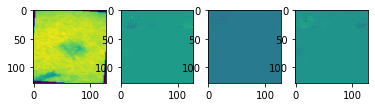

In [38]:
from matplotlib import pyplot as plt 
for i in range(4):
    plt.subplot(1, 4, i+1)
    if i == 0:
        plt.imshow(inputs[i, 0].detach().numpy())
    else:
        plt.imshow(attribution[0,i-1].detach().numpy())

plt.show()